# Introduction to the Monte Carlo

## 1.) Theoretical considerations & Model

Let us consider a one-dimensional potential well (double well) described by the function

$$U(x) = \frac{D_0}{a^4} \left( (x^2 - a^2)^2 + lx\right),$$

where $D_0$ is a measure of the depth of the well, while $a$ describes its width and $l$ its asymmetry. There is a one point particle defined by its position $x$ residing in the well. Let us couple the particle to a thermostat of a fixed temperature $1/\beta$. The particle coupled to the thermostat does not conserve energy, as it is being constantly exchanged with the thermostat. Consequently, the particle can be found at any position in the potential well. It can be shown, that realization of a particular position $x$ happens with a probability proportional to the *Boltzmann factor*:

$$P(x) \sim \exp(-\beta U(x)).$$

As it usually is with probabilities, $\int \textrm{d} P(x) = 1$, hence we can convert the proportionality ($\sim$) in the above relation into an equation. Let us define the *configuration integral* $Z$:
$$Z = \int \textrm{d}x \exp(-\beta U(x)) \quad \Longrightarrow \quad P(x) = \frac{\exp(-\beta U(x))}{Z}.$$

The ensemble average of any quantity $A(x)$ of the system is then defined as:

$$\langle A \rangle = \int \textrm{d}x A(x) P(x) = \frac{1}{Z} \int \textrm{d}x A(x) \exp(-\beta U(x)),$$

so basically, just an average of the quantity over all states (positions) weighted by the probability of their realization.

In this work-sheet, we will use Monte Carlo methods to estimate the ensemble average of the position of the particle in the well, $\langle x \rangle$; in other words, the ensemble average of the quantity $A(x) := x$.

**To run a code in a cell, press `Enter + Shift` upon entering the cell. 
On your first reading, just run all of the cells with the default setting.**

In [2]:
# import modules
import numpy as np # numerical operations
import time # stride for animations
import scipy.integrate as sci_integral # trapezoidal integration
import matplotlib.pyplot as plt # plotting
from IPython.display import clear_output # animations
import statistics 

# constants
x_min, x_max = -10, 10 # boundaries for the oscillator
vx_min, vx_max = -4, 4 # boundaries for the visualization
beta = 1.0 # 1/kT

# define functions for later
def potential(x, D0 = 1.0, a = 1.0, l = 0.9):
    '''calculate the double well potential'''
    U = ((D0 / a**4) * (x**2 - a**2)**2 + l*x)
    return U

def random_x(x_min = x_min, x_max = x_max):
    '''generate a random float in the (x_min, x_max) range'''
    return x_min + np.random.random() * (x_max - x_min)

def move_metropolis(old_x, beta = beta, displacement = 0.5):
    '''make MC move with Metropolis algorithm'''
    E_old = potential(old_x) # energy of the old configuration
    new_x = old_x + displacement*(np.random.random() - 0.5) # trial configuration with random displacement
    E_new = potential(new_x) # energy of the new configuration
 
    if E_new < E_old:
        # if E_new < E_old, accept the new
        return new_x
    else:
        # if E_new > E_old, accept with probability proportional to the boltzmann weight
        boltzmann = np.exp(-beta * (E_new - E_old)) # Boltzmann factor
        sample_probability = np.random.random() # sample probability to compare with the Boltzmann factor
        if boltzmann > sample_probability:
            return new_x
        else:
            return old_x

## 2.) Direct numerical integration

For one-dimensional system with one particle and "well-behaved" potential, we can simply calculate the energies and associated Boltzmann factors at selected positions, and carry out the ensemble average integration numerically using trapezoid (or any other) rule. This is what we will do it in this section. 

We know, that $U(x)$ diverges for $x \gg 0$ and $x \ll 0$, hence $P(x) = 0$ there. Therefore, we will replace the integral by a discrete sum in a bounded interval of positions $x_0 < x < x_1$, in which we move by increments of $\Delta x$. Hence
$$Z = \int \textrm{d}x \exp(-\beta U(x)) \approx \sum_i \Delta x \cdot \exp(-\beta U(x_0 + i\Delta x)),$$
$$\langle x \rangle = \frac{1}{Z} \int \textrm{d}x \ x \exp(-\beta U(x)) \approx \dfrac{1}{Z} \sum_i \Delta x \cdot (x_0 + i \Delta x) \cdot \exp(-\beta U(x_0 + i\Delta x)).$$

Execute the below cell to see the shape of the potential well, corresponding Boltzmann probabilities and the numerically calculated $\langle x \rangle$.

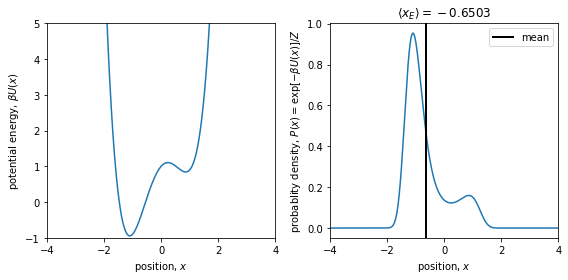

In [4]:
# create array of x and calculate the potential and Boltzmann probability
xs = np.linspace(x_min, x_max, num = 10000) # positions; here we know that outside of [x_min, x_max], U(x) is very high, hence P(x) = 0
Us = potential(xs) # energy
ps = np.exp(-beta * Us) # Boltzmann factor
Z = sci_integral.simps(ps, x = xs) # configuration integral
ps /= Z # normalize the factor to get the probabilities

# calculate the mean x by numerical integration
true_mean = sci_integral.simps(ps * xs, x = xs)
ps_range = ps.max() - ps.min()
vis_range = [-ps_range * 0.05, ps_range*1.05] # probability scale for plotting

# plot the potentials
fig, ax = plt.subplots(1, 2, figsize = (8,4), gridspec_kw = {'width_ratios': [1,1]})
for i in [0,1]:
    ax[i].set_xlabel('position, $x$')
    ax[i].set_xlim(vx_min, vx_max)
ax[0].set_ylim(-1,5)
ax[1].set_ylim(*vis_range)
ax[0].set_ylabel('potential energy, $βU(x)$')
ax[1].set_ylabel('probablity density, $P(x) = \exp [-βU(x)]/Z$')
ax[0].plot(xs,Us,)
ax[1].plot(xs,ps,)
ax[1].plot([true_mean,]*2, vis_range, linestyle = 'solid', color = 'black', linewidth = 2.0, label = 'mean')
ax[1].set_title("$\\langle x_E \\rangle = {:.4f}$".format(true_mean))
fig.tight_layout()
plt.legend(loc = 'best')
plt.show()

## 3.) Monte Carlo

Now we will use the Monte Carlo techniques to estimate the mean position of the particle, and we will compare it to the above method of *direct integration*.
In such a simple one-dimensional system, the direct integration can be considered, in principle, (numerically) exact solution, which we will treat as a reference result, which we wish to reproduce with the Monte Carlo method.
This exercise is supposed to demonstrate the main ideas of the Monte Carlo, but it does not really do a justice to its real strength.
It might appear, from this exercise, that the Monte Carlo is more expensive and less accurate than the direct integration.
The point is, however, that the direct integration is absolutely unfeasible for the multi-dimensional systems with many particles - there you have to use something different (f. e. Monte Carlo).

In here, we will use the importance sampling Monte Carlo scheme with the Metropolis algorithm to sample positions of the particle. Note that the Metropolis algorithm already samples positions in accordance with the Boltzmann distributions, so any further reweighing is undesirable. The mean of the values of positions generated, should converge to the real ensemble average of this quantity.

## 4.) Tasks

Below, you can run a Monte Carlo code, which samples positions and accumulates them in the `time_series` array. To access the mean, you can use for example `time_series.mean()`. The code also provides a visualization: On the left-hand-side figure, you can see time series of the sampled positions. On the right-hand-side figure, you can see the emerging probability distribution generated by the time series of the sampled positions and the mean calculated from this time series. Both mean and distributions are compared to the "exact" results given by the above direct integration.

1. run the Monte Carlo code with the default setting and observe which positions are being sampled the most. How do this positions relate to the shape of the potential well?
1. observe the emerging probability distribution generated by the sampled positions. Visually verify that this probability profile indeed eventually converges to the "exact" (Boltzmann) distribution.
1. explore the variance of the algorithm convergence: Run the Monte Carlo code with the default setting several times (the random seed is always automatically reset) and accumulate the mean positions into a set $X = \{ \langle x \rangle_1, \langle x \rangle_2, \dots, \langle x \rangle_M \}$. Calculate the mean and the standard deviation over samples in $X$. Does a non-zero variance in the $X$ mean that the algorithm is incorrect?
1. explore the rate of the algorithm convergence: Now repeat the step 3.) for different number of Monte Carlo steps. Plot the mean $\pm$ standard deviation over $X$ as a function of Monte Carlo steps carried out. Interpreet the plot.

In [5]:
N_moves = 10000 # MC moves
stride = 100 # period for visualization in units of MC moves
wait_time = 0.0 # at the end of each visualization cycle, wait this many seconds - SET TO ZERO TO MAKE SIMULATIONS FASTER!
Z = []
variances = []

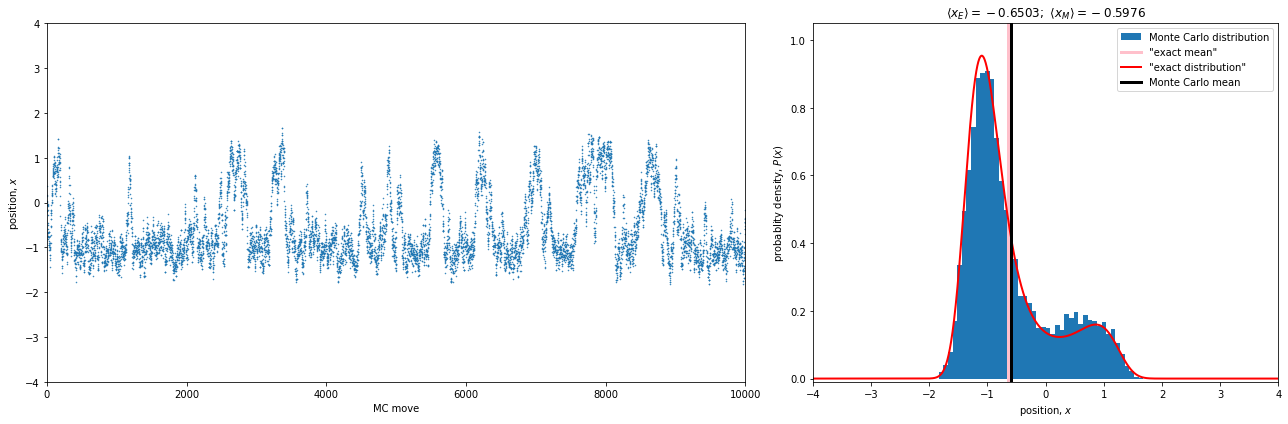

-0.5976418554445077
[-0.7439991684346973, -0.6108410415181048, -0.5976418554445077]
0.007709919052871262


In [9]:
# initialize
time_series, current_x = np.zeros((N_moves+1)), 0

# run the Monte Carlo
for move in range(N_moves+1):
    current_x = move_metropolis(current_x) # Monte Carlo move
    time_series[move] = current_x # store the returned configuration
    print(time_series)
    # visualization
    if move % stride == 0 and move > 0:
        mean = time_series[:move].mean()
        
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize = (18,6), gridspec_kw = {'width_ratios': [3,2]})
        ax[0].set_xlabel('MC move')
        ax[0].set_ylabel('position, $x$')
        ax[1].set_xlabel('position, $x$')
        ax[1].set_ylabel('probablity density, $P(x)$')
        ax[0].set_xlim(0,N_moves)
        ax[1].set_xlim(vx_min,vx_max)
        ax[0].set_ylim(vx_min,vx_max)
        ax[0].plot(time_series[:move], marker = '.', markersize = 1, linewidth = 0)
        ax[1].set_ylim(-ps_range * 0.01, ps_range * 1.1)
        ax[1].set_title("$\\langle x_E \\rangle = {:.4f}; \\ \\langle x_M \\rangle = {:.4f}$".format(true_mean, mean))
        ax[1].hist(time_series[:move], range = (vx_min, vx_max), bins = 100, density = True, label = 'Monte Carlo distribution')
        ax[1].plot([true_mean, true_mean], [-ps_range * 0.01, ps_range * 1.1], linewidth = 3.0, color = 'pink', label = '"exact mean"')
        ax[1].plot(xs, ps, linewidth = 2, markersize = 0, color = 'red', label = '"exact distribution"')
        ax[1].plot([mean, mean], [-ps_range * 0.01, ps_range * 1.1], linewidth = 3.0, color = 'black', label = 'Monte Carlo mean')
        ax[1].legend(loc = 'best')
        fig.tight_layout()
        plt.show()
        time.sleep(wait_time)
        
mean = time_series.mean()
print(mean)
Z.append(mean)
print(Z)
variances.append(statistics.variance(Z))
mean_variance = statistics.mean(variances)
print(mean_variance)